# 07 PoF with ARIMA

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *

bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')
bnb_close_values = bnb_data['Close']

In [2]:
future_period = 21
profit_of_future_log = covertToLogScale(computeProfitOfFuture(bnb_close_values, future_period))

Brenchmarking with trivial prediction: profit of future = 0

In [3]:
rmse0 = np.sqrt(np.mean(np.square(profit_of_future_log)))
rmse0

3.1750437867884274

#### [Model1] Using price value to predict profit of future

In [4]:
skip_count = 390

input_data = np.array(bnb_data['Close'][skip_count:-future_period]).reshape(-1, 1)
output_data = profit_of_future_log[skip_count:].reshape(-1, 1)

dataSize = len(input_data)
assert(dataSize == len(output_data))
windowSize = future_period * 2 # TODO:
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

input_scale = np.max(input_data)
output_scale = np.max(profit_of_future_log)
print(f"input_scale: {input_scale}")
print(f"output_scale: {output_scale}")

x_train, y_train, x_test, y_test, train_dataset, test_dataset = prepareDatasForSeriesModelTraining(input_data, output_data, windowSize, testSize)

dataSize: 1010
windowSize: 42
testSize: 303
input_scale: 676.967
output_scale: 5.841402995389024


In [5]:
neuronCount = 1024

# Create input to stacks
input = layers.Input(shape=(windowSize,1), name="stack_input")
x = input
x = tf.keras.layers.multiply([x, np.array([1./input_scale])])
x = tf.keras.layers.LSTM(neuronCount, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.LSTM(neuronCount, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.LSTM(neuronCount, activation='tanh', return_sequences=True)(x)
x = tf.keras.layers.LSTM(neuronCount, activation='tanh')(x)
x = tf.keras.layers.Dense(1, activation='tanh')(x)
x = tf.keras.layers.multiply([x, np.array([output_scale])])

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["mse"])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stack_input (InputLayer)    [(None, 42, 1)]           0         
                                                                 
 multiply (Multiply)         (None, 42, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 42, 1024)          4202496   
                                                                 
 lstm_1 (LSTM)               (None, 42, 1024)          8392704   
                                                                 
 lstm_2 (LSTM)               (None, 42, 1024)          8392704   
                                                                 
 lstm_3 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense (Dense)               (None, 1)                 1025  


Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch: 11.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 31: early stopping
10/10 [==============================] - 2s 65ms/step - loss: 7.2409 - mse: 7.2409
loss: 2.690886027825425
corr: 0.2339175024244949


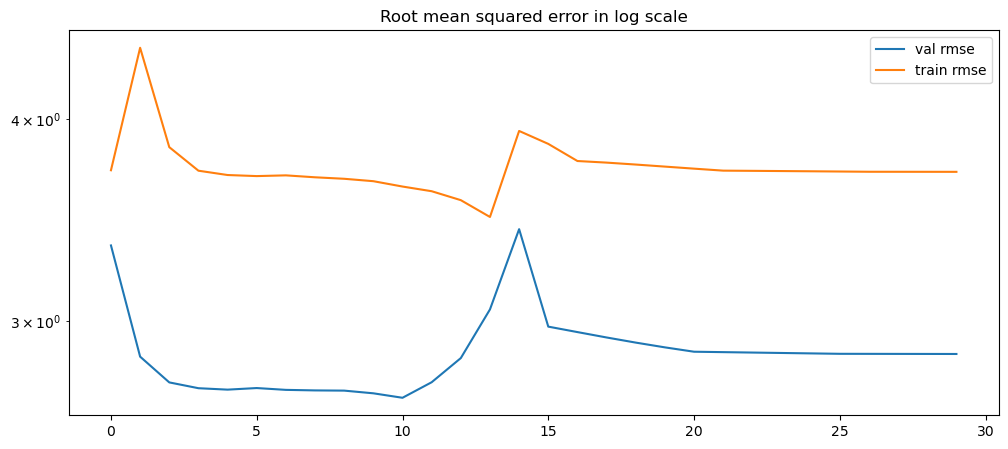

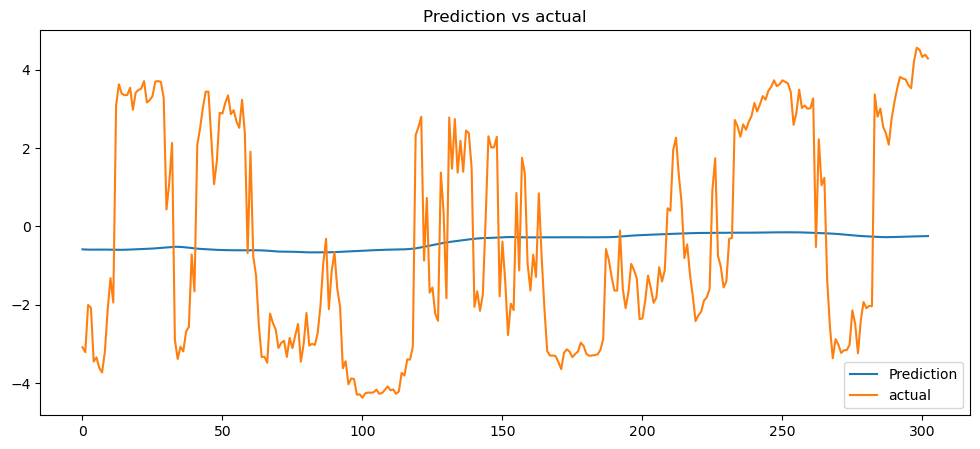

In [6]:
history1, rmse1, corr1 = standardTrainingAndReport(model1, x_test, y_test, train_dataset, test_dataset)

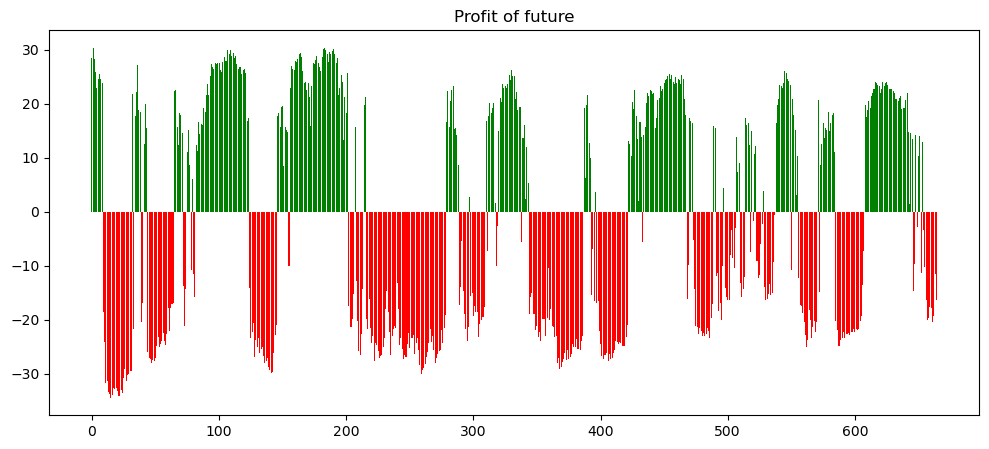

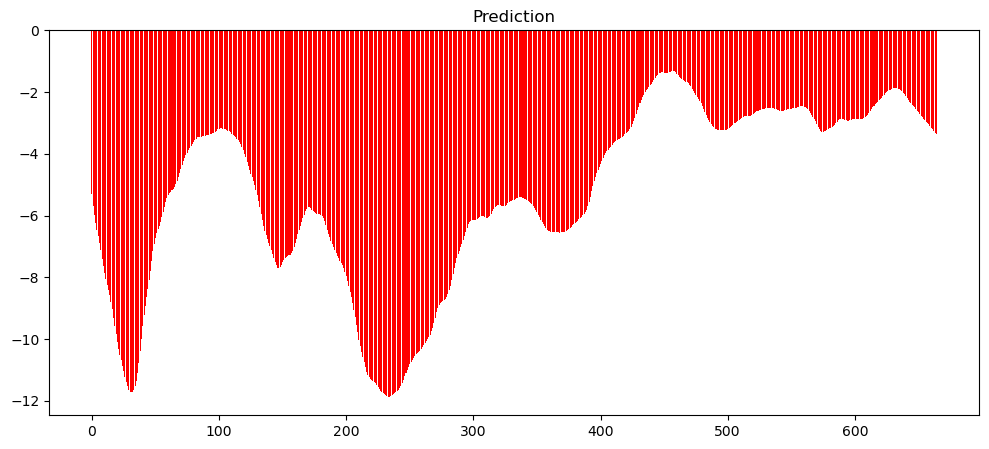

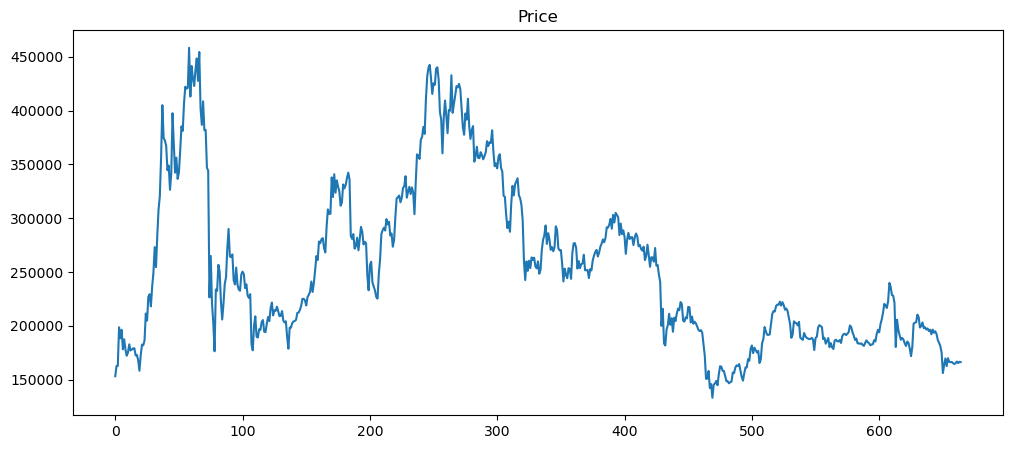

In [7]:
# check the training performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_train.reshape(-1) * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model1.predict(x_train)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction.reshape(-1))
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[0:len(x_train)].reshape(-1) * input_scale)
plt.title('Price')
plt.show()

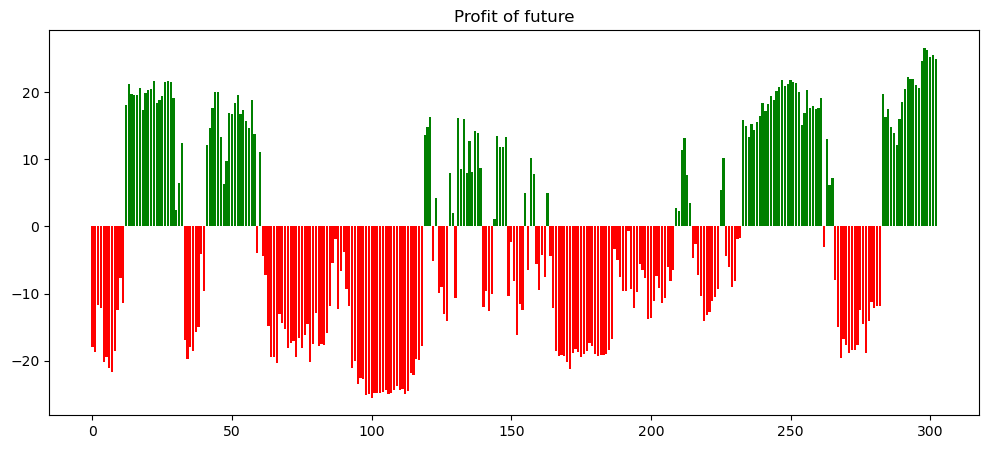

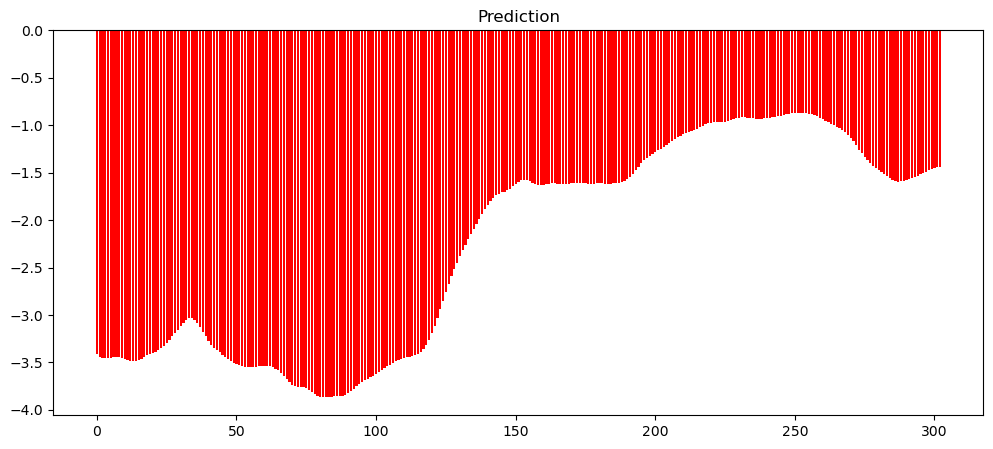

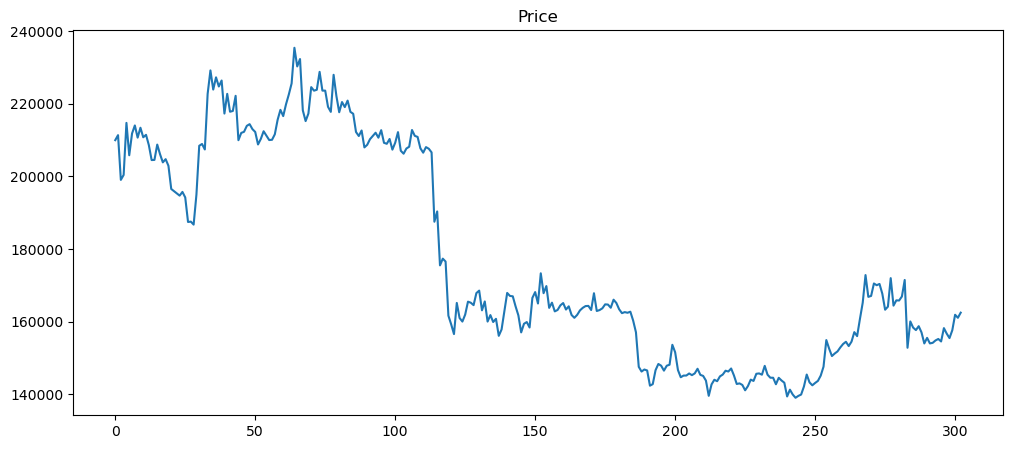

In [8]:
# check the testing performance

plt.figure(figsize=(12, 5))
plotBarColoredSign(y_test.reshape(-1) * output_scale)
plt.title('Profit of future')
plt.show()

prediction = model1.predict(x_test)
prediction = prediction.reshape(-1) * output_scale
plt.figure(figsize=(12, 5))
plotBarColoredSign(prediction.reshape(-1))
plt.title('Prediction')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(input_data[-len(x_test):].reshape(-1) * input_scale)
plt.title('Price')
plt.show()

Seems that the train is affected by imbalanced data. Let's study resampling next time